In [3]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from adjustText import adjust_text

# 设置绘图参数
sc.settings.set_figure_params(dpi=100, frameon=False)
plt.rcParams['figure.figsize'] = (10, 8)
sns.set_style("whitegrid")

# 读取已有的数据
combined_data_file = "a549_combined_data.h5ad"
combined = sc.read_h5ad(combined_data_file)
sc.pp.filter_cells(combined, min_genes=200)
sc.pp.filter_genes(combined, min_cells=100)
print(f"Combined data shape: {combined.shape}")

# 过滤掉'unsure'药物类型的细胞
combined = combined[combined.obs['drug'] != 'unsure']
print(f"Filtered data shape: {combined.shape}")

# 检查药物种类
print(f"Available drugs: {combined.obs['drug'].unique()}")
print(f"Number of drugs: {combined.obs['drug'].nunique()}")

Combined data shape: (246262, 29421)
Filtered data shape: (245003, 29421)
Available drugs: ['wild-type (wt) virus', 'irradiated a549 cells (6 gy γ-', 'infected (cal07, 16 hours, rep', 'car t cell therapy with suv39h', 'infected with h3n2 (a/perth/16', ..., 'irradiation (ir 6h)', 'acme hs dissociation', 'lentiviral pool for expression', 'infected with h1n1 (a/californ', 'bexmarilimab']
Length: 21
Categories (21, object): ['6 gy γ-ray treatment', '8 hours post infection', 'acme hs dissociation', 'antineoplastic agents, mixed m', ..., 'lentiviral pool for expression', 'ns1 4xstop (mutant)', 'ritonavir, gemcitabine, cispla', 'wild-type (wt) virus']
Number of drugs: 21


In [44]:
combined.obs['drug'].unique().tolist()

['wild-type (wt) virus',
 'irradiated a549 cells (6 gy γ-',
 'infected (cal07, 16 hours, rep',
 'car t cell therapy with suv39h',
 'infected with h3n2 (a/perth/16',
 '8 hours post infection',
 'irradiation',
 'ritonavir, gemcitabine, cispla',
 'glyconanomaterials for combati',
 'control',
 'ns1 4xstop (mutant)',
 'infected with h3n2, cetuximab ',
 'in vitro culture of ipsc-rpe',
 '6 gy γ-ray treatment',
 'car t cell therapy, suv39h1 kn',
 'antineoplastic agents, mixed m',
 'irradiation (ir 6h)',
 'acme hs dissociation',
 'lentiviral pool for expression',
 'infected with h1n1 (a/californ',
 'bexmarilimab']

In [ ]:
['wild-type (WT) virus',
 'irradiated A549 cells (6 Gy γ-ray treatment)',
 'Infected (Cal07, 16 hours, Replicate 2)',
 'CAR T cell therapy with SUV39H1 knockout',
 'infected with H3N2 (A/Perth/16/2009)',
 '8 hours post infection',
 'irradiation',
 'Ritonavir, gemcitabine, cisplatin',
 'glyconanomaterials for combating bacterial infections',
 'NS1 4xstop (mutant)',
 'infected with H3N2, Cetuximab (anti-EGFR therapy)',
 'in vitro culture of iPSC-RPE',
 '6 Gy γ-ray treatment',
 'CAR T cell therapy, SUV39H1 knockout, CD19 tumor cell treatment',
 'irradiation (IR 6h)',
 'Infected with H3N2 (A/Perth/16/2009), 16 hours post infection',
 'ACME HS dissociation',
 'lentiviral pool for expression of 120 gRNAs, tamoxifen, puromycin',
 'Infected with H1N1 (A/California/07/2009), 8 hours post infection',
 'infected with H1N1 (A/California/07/2009)',
 'Bexmarilimab']

In [45]:
combined.obs['perturbation'].unique().tolist()

['wild-type (WT) virus',
 'irradiated A549 cells (6 Gy γ-ray treatment)',
 'Infected (Cal07, 16 hours, Replicate 2)',
 'CAR T cell therapy with SUV39H1 knockout',
 'infected with H3N2 (A/Perth/16/2009)',
 '8 hours post infection',
 'irradiation',
 'Ritonavir, gemcitabine, cisplatin',
 'glyconanomaterials for combating bacterial infections',
 'uninfected (mock treatment)',
 'NS1 4xstop (mutant)',
 'infected with H3N2, Cetuximab (anti-EGFR therapy)',
 'in vitro culture of iPSC-RPE',
 'mixed sample treatments include DMSO, ARS-1620, and Vemurafenib',
 '6 Gy γ-ray treatment',
 'CAR T cell therapy, SUV39H1 knockout, CD19 tumor cell treatment',
 'antineoplastic agents, mixed micelles for drug delivery',
 'irradiation (IR 6h)',
 'Infected with H3N2 (A/Perth/16/2009), 16 hours post infection',
 'uninfected (Mock)',
 'infected with H3N2 (A/Perth/16/2009), 16 hours post infection',
 'ACME HS dissociation',
 'CAR T cell therapy, SUV39H1 knockout',
 'lentiviral pool for expression of 120 gRNAs, ta

: 

In [10]:
results_dir = "a549_perturbation_analysis_loka"
fig_dir = os.path.join(results_dir, "figures_umap")
os.makedirs(fig_dir, exist_ok=True)

In [5]:
# ------------ 数据预处理 ------------
# 标准化数据
print("Performing normalization...")
sc.pp.normalize_total(combined, target_sum=1e4)
sc.pp.log1p(combined)

# 找出高变异基因
print("Identifying highly variable genes...")
sc.pp.highly_variable_genes(combined, min_mean=0.0125, max_mean=3, min_disp=0.5)
print(f"Number of highly variable genes: {sum(combined.var.highly_variable)}")

# 保留高变异基因用于降维
high_var_combined = combined[:, combined.var.highly_variable]
print(f"High variable data shape: {high_var_combined.shape}")

# 缩放数据用于降维
sc.pp.scale(high_var_combined, max_value=10)

Performing normalization...


/tools/anaconda3/envs/llk/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Identifying highly variable genes...


/tools/anaconda3/envs/llk/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Number of highly variable genes: 5211
High variable data shape: (245003, 5211)


/tools/anaconda3/envs/llk/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


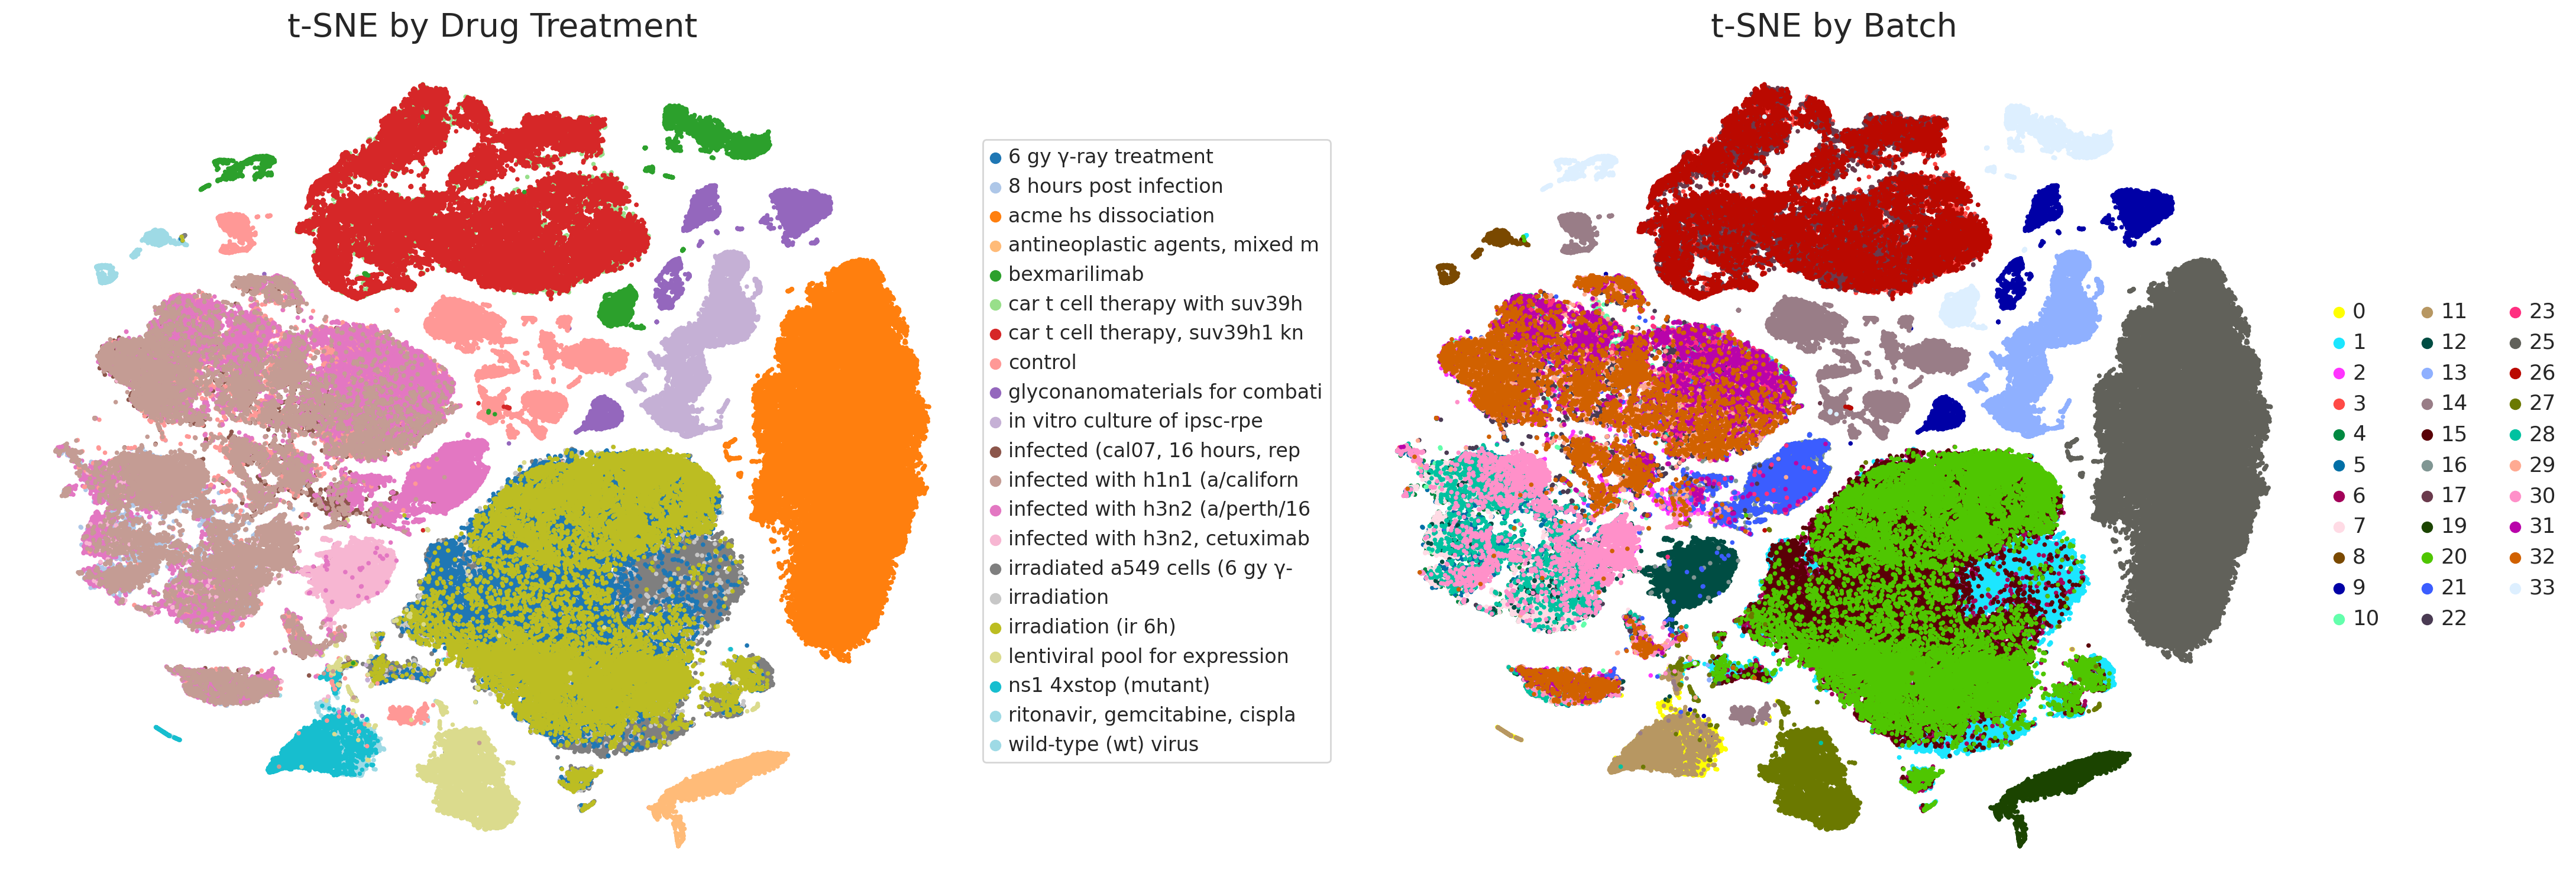

In [42]:
# 创建UMAP可视化
fig_dir = os.path.join(results_dir, "figures_umap_v2")
os.makedirs(fig_dir, exist_ok=True)

plt.figure(figsize=(22, 8))

# 按药物着色
ax1 = plt.subplot(1, 2, 1)
sc.pl.umap(high_var_combined, color='drug', ax=ax1, show=False, title='UMAP by Drug Treatment', 
           palette='tab20', size=30)
ax1.legend(bbox_to_anchor=(1, 0.9), loc='upper left', fontsize=12)
ax1.set_title('UMAP by Drug Treatment', fontsize=20)


# 获取批次信息（如果有）
if 'batch' in high_var_combined.obs.columns:
    ax2 = plt.subplot(1, 2, 2)
    sc.pl.umap(high_var_combined, color='batch', ax=ax2, show=False, title='UMAP by Batch', size=30)
    # ax2.legend(bbox_to_anchor=(1, 0.9), loc='upper left', fontsize=12, borderaxespad=0)
    ax2.set_title('UMAP by Batch', fontsize=20)
else:
    # 如果没有批次信息，可以检查其他潜在的细胞特征
    other_features = ['n_genes', 'n_counts'] if 'n_counts' in high_var_combined.obs.columns else ['n_genes']
    ax2 = plt.subplot(1, 2, 2)
    sc.pl.umap(high_var_combined, color=other_features[0], ax=ax2, show=False, title=f'UMAP by {other_features[0]}')

plt.tight_layout()
plt.savefig(f'{fig_dir}/umap_visualization.pdf', dpi=500, bbox_inches='tight')
plt.show()

# 创建t-SNE可视化
plt.figure(figsize=(22, 8))

# 按药物着色
ax1 = plt.subplot(1, 2, 1)
sc.pl.tsne(high_var_combined, color='drug', ax=ax1, show=False, title='t-SNE by Drug Treatment',
          palette='tab20', size=30, legend_loc='upper left', legend_fontsize=12)
ax1.legend(bbox_to_anchor=(1, 0.9), loc='upper left', fontsize=12)
ax1.set_title('t-SNE by Drug Treatment', fontsize=20)

# 检查细胞数量/基因数量等特征
ax2 = plt.subplot(1, 2, 2)
# sc.pl.tsne(high_var_combined, color='n_genes', ax=ax2, show=False, title='t-SNE by Number of Genes')
sc.pl.tsne(high_var_combined, color='batch', ax=ax2, show=False, title='t-SNE by Batch', size=30)
ax2.set_title('t-SNE by Batch', fontsize=20)

plt.tight_layout()
plt.savefig(f'{fig_dir}/tsne_visualization.pdf', dpi=500, bbox_inches='tight')
plt.show()